# 0. Setup

In [1]:
# reload all modules every time before executing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import sys, types

import numpy as np

In [3]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    print('adding `recover_core_lib` to sys')
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

adding `recover_core_lib` to sys


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# this automatically displays all plots, even if we don't have plt.show()
# this also makes all plots interactive
%matplotlib widget

# 1. Load Data

In [6]:
from collections import defaultdict

In [7]:
BASE_DIR = Path('../data/experiment_01/')
exp_dirs = sorted([d for d in BASE_DIR.iterdir() if d.is_dir()])
print(f'Found {len(exp_dirs)} experiment directories')
exp_dirs

Found 8 experiment directories


[PosixPath('../data/experiment_01/cube_pos1_29_12_Time_19_16_40'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_03_39'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_13_50'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_27_21'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_29_43'),
 PosixPath('../data/experiment_01/cube_pos4_29_12_Time_19_24_21'),
 PosixPath('../data/experiment_01/cube_pos5_29_12_Time_19_22_12'),
 PosixPath('../data/experiment_01/cube_pos6_29_12_Time_19_20_07')]

In [8]:
def load_data(exp_dirs) -> dict:
    """Load recovery and metadata from an experiment directory."""

    duplicate_idx_map = defaultdict(int)
    data = {}

    for exp_dir in exp_dirs:
        recovery = np.load(exp_dir / 'RECOVERY.npz', allow_pickle=True)
        fs = recovery['run_opt'].item()['cam_params']['camera_FPS'] # use frames-per-second as sampling-frequency

        object = str(exp_dir).split('/')[-1].split('_')[0]
        position = int(str(exp_dir).split('/')[-1].split('_')[1][3:])

        key = (object, position)
        duplicate_idx_map[key] += 1
        duplicate_idx = duplicate_idx_map[key]

        name = f'{object}-pos{position}-{duplicate_idx:02}'
        shifts_raw = recovery['all_shifts']

        time = np.arange(shifts_raw.shape[1]) / fs

        d = {
            'object': object,
            'position': position,
            'duplicate_idx': duplicate_idx,
            'fs': fs,
            'path': exp_dir,
            'shifts_raw': shifts_raw,
            'time': time,
        }
        data[name] = d
    return data

In [9]:
data = load_data(exp_dirs)
len(data)

8

In [10]:
list(data.keys())

['cube-pos1-01',
 'cube-pos2-01',
 'cube-pos2-02',
 'cube-pos3-01',
 'cube-pos3-02',
 'cube-pos4-01',
 'cube-pos5-01',
 'cube-pos6-01']

In [11]:
list(list(data.values())[0].keys())

['object', 'position', 'duplicate_idx', 'fs', 'path', 'shifts_raw', 'time']

# 2. Compute FFT

In [14]:
def shifts_to_fft(shifts, fs, min_freq=None, max_freq=None):
    # compute fft values and frequencies
    fft_val = np.fft.rfft(shifts, axis=1)
    n_samples = shifts.shape[1]
    freq = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    if min_freq is not None and max_freq is not None:
        mask = (freq >= min_freq) & (freq <= max_freq)
        fft_val, freq = fft_val[:, mask, :], freq[mask]
    return fft_val, freq

In [15]:
def fft_magnitude(fft_vals, return_std=False):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.abs(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.abs(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.abs(fft_vals).mean()
        return (fft_mag_mean, np.abs(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

In [16]:
def fft_angle(fft_vals, return_std=False):
    """Compute fft angle and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.angle(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.angle(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.angle(fft_vals).mean()
        return (fft_mag_mean, np.angle(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

# 3. Clean Data

In [17]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

In [18]:
def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, _, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [19]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

In [27]:
def plot_clean_data(shifts, fs, xlim=(None, None)):
    # fft for raw signal
    fft_vals, freq = shifts_to_fft(shifts, fs)

    # fft for bandpass filter
    bp_shifts = bandpass_filter(shifts, fs)
    bp_fft_vals, bp_freq = shifts_to_fft(bp_shifts, fs)

    # fft for bandpass filter + hann window
    wd_shifts = hann_window(bp_shifts)
    wd_fft_vals, wd_freq = shifts_to_fft(wd_shifts, fs)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(freq, fft_magnitude(fft_vals), label='raw')
    ax.plot(bp_freq, fft_magnitude(bp_fft_vals), label='bandpass filter')
    ax.plot(wd_freq, fft_magnitude(wd_fft_vals), label='bandpass filter + hann window')
    ax.set(xlim=xlim, ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
    ax.legend()
    fig.suptitle('Clean the Data')
    return fig

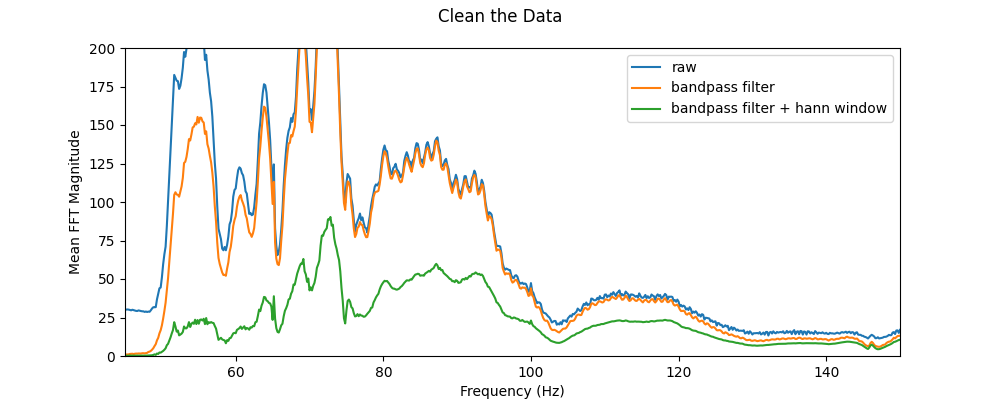

In [28]:
d = list(data.values())[0]
fig = plot_clean_data(d['shifts_raw'], d['fs'], xlim=(45, 150))

The fft vals looks much cleaner with bandpass filter + hann window. Let's define a function to clean the shifts and compute the fft on this cleaned data.

In [30]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

Now let's take a look at all the frequencies.

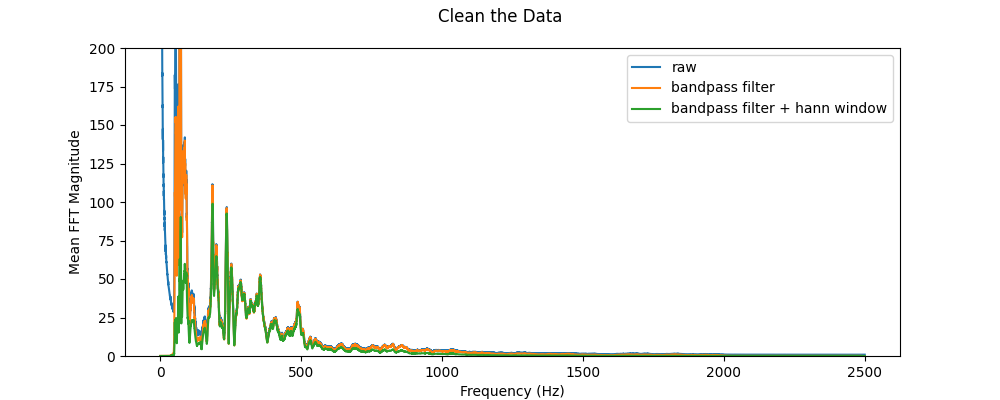

In [29]:
fig = plot_clean_data(d['shifts_raw'], d['fs'])

Notice that there isn't really any signal after 1000 hz.

In [31]:
MIN_FREQ, MAX_FREQ = 50, 1_000

In [32]:
for name, d in data.items():
    d['shifts'] = clean_shifts(d['shifts_raw'], d['fs'])
    fft_val, freq = shifts_to_fft(d['shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_vals'], d['freqs'] = fft_val, freq

In [33]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs']

# 4. Compute Modes

In [34]:
from scipy.signal import find_peaks
from matplotlib.widgets import RangeSlider

In [35]:
def find_modes(freqs, fft_vals, n_modes=5, min_distance=100):
    """Find the top n_modes frequency peaks from mean FFT magnitude (averaged over lasers + x/y coordinate).

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """

    mean_mag = fft_magnitude(fft_vals)
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    mode_freqs_idx = np.array(sorted(peaks[top_indices]))

    mode_freqs = freqs[mode_freqs_idx]
    mode_fft_vals = fft_vals[:, mode_freqs_idx, :]
    return mode_freqs_idx, mode_freqs, mode_fft_vals

In [36]:
def plot_fft_with_modes(data, mode_freq_key='_mode_freqs', mode_fft_vals_idx='_mode_fft_vals'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    axes = axes.flatten()

    min_freq = min([min(d.get(mode_freq_key, d['freqs'].min())) for d in data.values()])
    max_freq = max([max(d.get(mode_freq_key, d['freqs'].max())) for d in data.values()])

    for d in data.values():
        # skip duplicates
        if d['duplicate_idx'] != 1: continue
        ax_idx = d['position'] - 1
        ax = axes[ax_idx]
        freqs, fft_vals = d['freqs'], d['fft_vals']

        mean, std = fft_magnitude(fft_vals, return_std=True)
        ax.plot(freq, mean, lw=0.8)
        ax.fill_between(freq, mean - std, mean + std, alpha=0.3)

        if mode_freq_key in d:
            for mode_freq, mode_fft_val in zip(d[mode_freq_key], d['_mode_fft_vals']):
                mode_fft_mag = fft_magnitude(mode_fft_val)
                ax.axvline(mode_freq, color='red', linestyle='--', alpha=0.7, lw=1)
                ax.scatter([mode_freq], [mode_fft_mag], color='red', s=50, zorder=5)
                ax.annotate(f'{mode_freq:.0f} Hz', (mode_freq, mode_fft_mag), textcoords='offset points',
                           xytext=(5, 5), fontsize=8, color='red')

        ax.set(title=f'Position {d['position']}', xlim=(min_freq*0.9, max_freq*1.1))
        ax.grid(True, alpha=0.3)
        n_modes = len(d[mode_freq_key])

    # 1. Set your labels as you did before
    for ax in axes[-3:]:
        ax.set_xlabel('Frequency (Hz)')

    for ax in axes[::3]:
        ax.set_ylabel('Magnitude')

    # 2. Clean up the ticks based on the presence of those labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', labelbottom=bool(ax.get_xlabel()), bottom=bool(ax.get_xlabel()))
        ax.tick_params(axis='y', labelleft=bool(ax.get_ylabel()), left=bool(ax.get_ylabel()))


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    title_suffix = f"\n{d[mode_freq_key]}" if 'cannonical' in mode_freq_key else ""
    fig.suptitle(f'FFT Magnitude {n_modes} modes'+title_suffix, fontsize=12)

    # Add range slider for frequency zoom
    ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(ax_slider, 'Freq (Hz)', freq.min(), freq.max(), valinit=(min_freq*0.9, max_freq*1.1))

    def update(val):
        freq_min, freq_max = val
        for ax in axes: ax.set_xlim(freq_min, freq_max)
        fig.canvas.draw_idle()
    slider.on_changed(update)

    # Keep a reference to the slider to prevent garbage collection
    fig._slider = slider
    return fig

In [37]:
def plot_mode_frequency_overlap(data):
    """Bubble plot showing mode frequencies across positions.

    X-axis: frequency (Hz)
    Y-axis: position
    Marker size: proportional to mean FFT magnitude at that mode
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    positions = []
    frequencies = []
    magnitudes = []

    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue

        pos = d['position']
        for mode_freq, mode_fft_val in zip(d['_mode_freqs'], d['_mode_fft_vals']):
            mag = fft_magnitude(mode_fft_val).item()
            positions.append(pos)
            frequencies.append(mode_freq)
            magnitudes.append(mag)

    n_modes = len(d['_mode_freqs'])
    positions = np.array(positions)
    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)

    # Draw horizontal lines for each position
    unique_positions = sorted(set(positions))
    for pos in unique_positions:
        ax.axhline(pos, color='gray', linestyle='-', alpha=0.3, linewidth=1)

    # Normalize magnitudes for marker sizes (scale to reasonable range)
    size_scale = 1_200
    sizes = (magnitudes / magnitudes.max()) * size_scale

    # Color by even/odd position
    colors = ['tab:blue' if pos % 2 == 0 else 'tab:orange' for pos in positions]

    scatter = ax.scatter(frequencies, positions, s=sizes, alpha=0.6,
                         c=colors, edgecolor='black', linewidth=0.5)

    # Add magnitude labels on each bubble
    for freq, pos, mag in zip(frequencies, positions, magnitudes):
        ax.annotate(f'{freq:.0f}', (freq, pos), ha='center', va='center',
                    fontsize=7, fontweight='bold', color='black')

    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Position', fontsize=11)
    ax.set_yticks(unique_positions)
    ax.grid(True, alpha=0.3, axis='x')

    # Add size legend
    legend_sizes = [0.25, 0.5, 1.0]
    legend_labels = [f'{int(s * magnitudes.max()):.0f}' for s in legend_sizes]
    for s, label in zip(legend_sizes, legend_labels):
        ax.scatter([], [], s=s * size_scale, c='gray', alpha=0.6, edgecolor='black')

    # Add color legend for even/odd
    ax.scatter([], [], s=100, c='tab:blue', alpha=0.6, edgecolor='black', label='Even positions')
    ax.scatter([], [], s=100, c='tab:orange', alpha=0.6, edgecolor='black', label='Odd positions')
    ax.legend(title='Position Parity', loc='upper right', frameon=True)

    fig.suptitle(f'{n_modes} Mode Frequencies Across Positions\n(marker size ~ mean FFT magnitude)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig

Let's compute the mode for each position by looking at the peaks of every FFT magnitude. Note: here each position has a different mode. We will "cannonacalize" the modes later.

Play around with the `n_samples`, `min_distance` parameters until they look right by inspecting the two plots.

In [38]:
# play around with these parameters until they look right using the plot_fft_by_position function
n_modes = 5 # 10
min_distance = 100

for name, d in data.items():
    mode_freqs_idx, mode_freqs, mode_fft_vals = find_modes(d['freqs'], d['fft_vals'], n_modes, min_distance)
    d['_mode_freqs_idx'], d['_mode_freqs'], d['_mode_fft_vals'] = mode_freqs_idx, mode_freqs, mode_fft_vals

In [39]:
d['_mode_freqs']

array([ 73.        ,  92.66666667, 185.83333333, 236.        ,
       355.16666667])

In [40]:
d['_mode_fft_vals'].shape

(100, 5, 2)

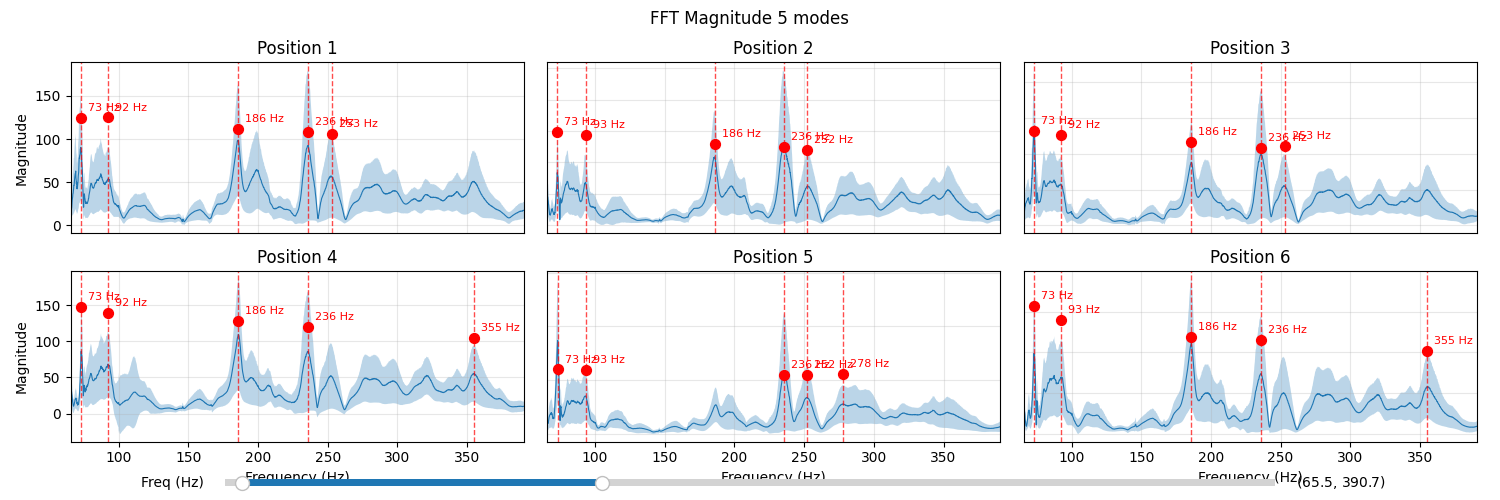

In [41]:
fig = plot_fft_with_modes(data)

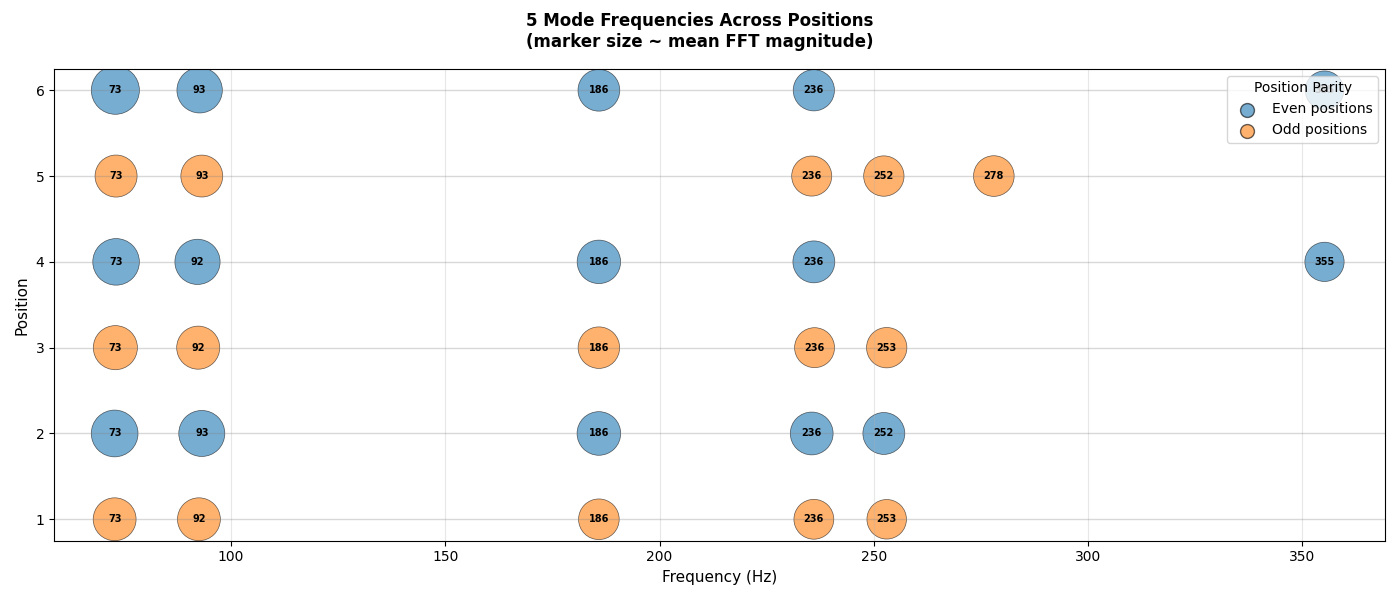

In [42]:
fig = plot_mode_frequency_overlap(data)
plt.show()

Based on our graphs, let's define our canonical modes as the modes from position 3. The canonical modes do not have a '_' in their key names.

In [43]:
list(data['cube-pos3-01'].keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals']

In [44]:
# Use mode frequencies from position 3 as the canonical reference
canonical_mode_freqs = data['cube-pos3-01']['_mode_freqs']

for name, d in data.items():
    # Store the canonical frequencies
    d['mode_freqs'] = canonical_mode_freqs

    # Find the closest frequency index in THIS position's frequency array for each canonical mode frequency
    freq_indices = []
    for target_freq in canonical_mode_freqs:
        idx = np.argmin(np.abs(d['freqs'] - target_freq))
        freq_indices.append(idx)

    d['mode_freqs_idx'] = np.array(freq_indices)

    # Extract FFT values at those indices from THIS position's fft_vals
    d['mode_fft_vals'] = d['fft_vals'][:, freq_indices, :]

In [45]:
d['mode_freqs']

array([ 73.        ,  92.33333333, 185.83333333, 236.16666667,
       253.        ])

In [46]:
d['mode_freqs_idx']

array([ 138,  254,  815, 1117, 1218])

# 5. Sync Phases

In [55]:
def sync_phases(fft_vals, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals_synced = fft_vals.copy()             # copy
    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref)**2 + eps)    # unit complex
    fft_vals_synced *= phase[None, :, None]       # broadcast over lasers and xy
    return fft_vals_synced

In [56]:
def get_gradients(fft_vals, n_lasers):
    """Extract real-valued gradients from complex FFT values, reshaped to (n_modes, 2, grid, grid).

    Args:
        fft_vals: shape (n_lasers^2, n_modes, 2) - complex FFT values
        n_lasers: grid dimension (e.g., 10 for 10x10 grid)

    Returns:
        gradients: shape (n_modes, 2, n_lasers, n_lasers) - real-valued gradients
                   Access as gradients[mode_idx, 0] for dx, gradients[mode_idx, 1] for dy
    """
    fft_vals = np.real(fft_vals)  # shape: (100, n_modes, 2)
    # Reshape: (100, n_modes, 2) -> (10, 10, n_modes, 2) -> (n_modes, 2, 10, 10)
    gradients = fft_vals.reshape(n_lasers, n_lasers, -1, 2)
    gradients = gradients.transpose(2, 3, 0, 1)  # (n_modes, 2, n_lasers, n_lasers)
    return gradients

In [57]:
for name, d in data.items():
    d['synced_fft_vals'] = sync_phases(d['fft_vals'])
    d['synced_mode_fft_vals'] = sync_phases(d['mode_fft_vals'])
    n_lasers = int(np.sqrt(d['shifts'].shape[0]))
    d['synced_mode_fft_gradients'] = get_gradients(d['synced_mode_fft_vals'], n_lasers)  # shape: (n_modes, 2, 10, 10)

In [58]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_mode_fft_gradients']

In [59]:
synced_mode_fft_val = d['synced_mode_fft_vals'][:, 0]
x = synced_mode_fft_val[:, 0].reshape(10, 10)
y = synced_mode_fft_val[:, 1].reshape(10, 10)
x

array([[ 1.        +1.10066803e-17j,  0.72223907+3.19648077e-02j,
         0.40644298+5.69650542e-02j,  0.33642538+5.20224678e-02j,
         0.11174055+5.20452489e-02j, -0.05369916+6.39630105e-02j,
        -0.11057838+4.95065730e-02j, -0.33056975+5.41157990e-02j,
        -0.34722911+2.34209009e-02j, -0.75856585+5.39501045e-02j],
       [ 0.97196502-7.89924693e-03j,  0.59992987+2.53879009e-02j,
         0.48318678+2.70705286e-02j,  0.35469547+3.90288940e-02j,
         0.07353434+4.10291902e-02j, -0.03462635+4.38395043e-02j,
        -0.13687826+4.50385659e-02j, -0.25900128+4.50520269e-02j,
        -0.4125068 +4.94003108e-02j, -0.66035567+4.75429224e-02j],
       [ 0.88600778-2.17474973e-02j,  0.58145937+1.05453531e-02j,
         0.46252064+1.28833045e-02j,  0.33473093+2.23402974e-02j,
         0.26041738+2.27894938e-02j,  0.02418086+3.52160588e-02j,
        -0.19184838+4.40839431e-02j, -0.39314746+4.54548235e-02j,
        -0.47302423+4.67150138e-02j, -0.77206294+5.07573102e-02j],
       

In [60]:
d['synced_mode_fft_gradients'].shape

dx = d['synced_mode_fft_gradients'][0, 0]
dy = d['synced_mode_fft_gradients'][0, 1]

dx

array([[ 1.        ,  0.72223907,  0.40644298,  0.33642538,  0.11174055,
        -0.05369916, -0.11057838, -0.33056975, -0.34722911, -0.75856585],
       [ 0.97196502,  0.59992987,  0.48318678,  0.35469547,  0.07353434,
        -0.03462635, -0.13687826, -0.25900128, -0.4125068 , -0.66035567],
       [ 0.88600778,  0.58145937,  0.46252064,  0.33473093,  0.26041738,
         0.02418086, -0.19184838, -0.39314746, -0.47302423, -0.77206294],
       [ 0.76772672,  0.56196757,  0.38040794,  0.30463569,  0.0997676 ,
        -0.05060809, -0.14660722, -0.37400771, -0.50976589, -0.7166706 ],
       [ 0.67094506,  0.45730729,  0.37056267,  0.28573226, -0.01232683,
        -0.10224381, -0.206649  , -0.32573932, -0.41968186, -0.72901504],
       [ 0.62865624,  0.44968241,  0.21339534,  0.1316311 ,  0.19571062,
         0.07242977, -0.2110847 , -0.24301446, -0.4107718 , -0.56889337],
       [ 0.4927677 ,  0.34101217,  0.27141082,  0.23771059,  0.08771787,
        -0.04041522, -0.02788113, -0.21117229

Visualize the mode shapes as quiver plots. Each subplot shows one mode, and you can toggle different box positions on/off to compare their vibration patterns.

{0: np.float64(10.193699458388798), 1: np.float64(14.115865641612157), 2: np.float64(7.250482203191098), 3: np.float64(80.63398642340206), 4: np.float64(32.30189567779856)}


/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_36660/3370040622.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


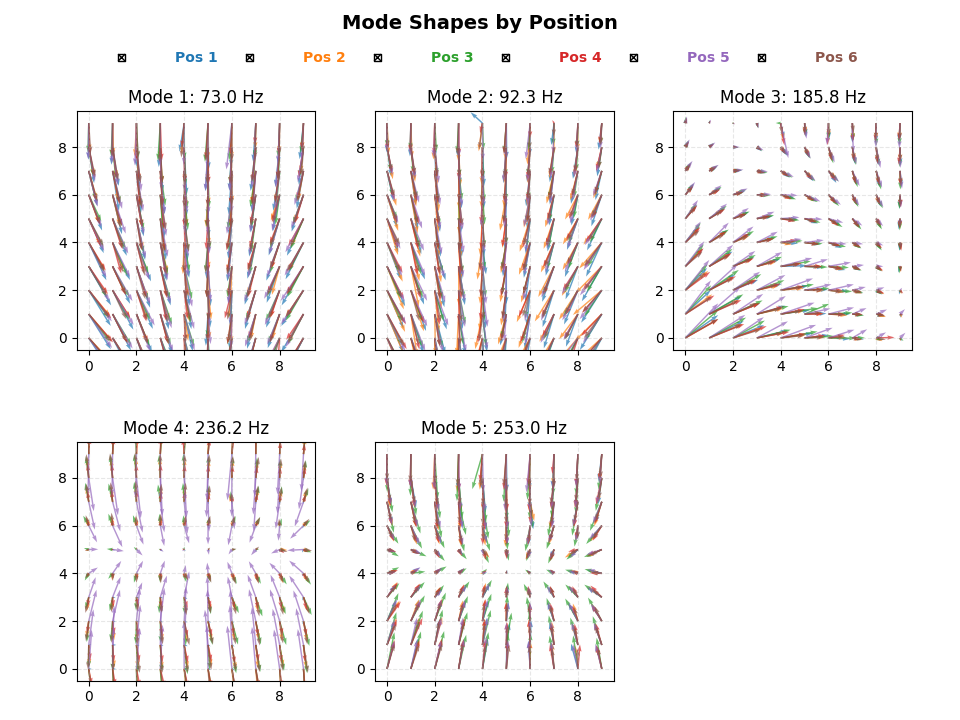

In [68]:
from matplotlib.widgets import CheckButtons

# Color palette for positions
POSITION_COLORS = {
    1: '#1f77b4',  # blue
    2: '#ff7f0e',  # orange
    3: '#2ca02c',  # green
    4: '#d62728',  # red
    5: '#9467bd',  # purple
    6: '#8c564b',  # brown
}


def plot_mode_quivers(data, n_cols=3, scale_per_mode=False):
    """
    Interactive quiver plot showing mode shapes for all positions.

    Each subplot = one mode. Toggle positions on/off with checkboxes.
    Quiver arrows show (dx, dy) shifts at each laser point for that mode.

    Args:
        data: dict of experiment data
        n_cols: number of columns in subplot grid
        scale_per_mode: if True, each mode is scaled independently for better visibility
    """
    # Get positions (skip duplicates)
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))

    # Get dimensions from first entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    # Grid coordinates
    X, Y = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))

    # Setup figure with space for horizontal checkbox bar at top
    n_rows = int(np.ceil(n_modes / n_cols))
    fig = plt.figure(figsize=(3.2*n_cols, 3*n_rows + 1.2))
    fig.suptitle('Mode Shapes by Position', fontsize=14, fontweight='bold', y=0.98)

    # Leave space at top for title and checkboxes
    gs = fig.add_gridspec(n_rows, n_cols, top=0.85, bottom=0.05, left=0.08, right=0.95, hspace=0.35, wspace=0.25)
    axes = [fig.add_subplot(gs[i // n_cols, i % n_cols]) for i in range(n_modes)]

    # Configure mode axes
    for i, ax in enumerate(axes):
        ax.set_xlim(-0.5, n_lasers - 0.5)
        ax.set_ylim(-0.5, n_lasers - 0.5)
        ax.set_aspect('equal')
        ax.set_title(f'Mode {i+1}: {mode_freqs[i]:.1f} Hz')
        ax.grid(True, alpha=0.3, linestyle='--')

    # State tracking
    active = {pos: True for pos in positions}
    quivers = {}  # (mode_idx, position) -> quiver object

    def compute_scale():
        """Compute quiver scale from active data."""
        if scale_per_mode:
            # Separate scale per mode
            scales = {}
            for mode_idx in range(n_modes):
                max_mag = 0
                for pos in positions:
                    if not active[pos]:
                        continue
                    d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
                scales[mode_idx] = max_mag / 0.2 if max_mag > 0 else 1.0
            return scales
        else:
            # Global scale: max across all modes and positions
            max_mag = 0
            for pos in positions:
                if not active[pos]:
                    continue
                d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                for mode_idx in range(n_modes):
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
            return max_mag / 0.2 if max_mag > 0 else 1.0

    def draw():
        """Redraw all quivers."""
        # Clear existing
        for q in quivers.values(): q.remove()
        quivers.clear()

        if not any(active.values()):
            fig.canvas.draw_idle()
            return

        scale = compute_scale()
        print(scale)

        # Draw quivers for active positions
        for pos in positions:
            if not active[pos]:
                continue
            d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
            color = POSITION_COLORS[pos]

            for mode_idx, ax in enumerate(axes):
                # Gradients shape: (n_modes, 2, n_lasers, n_lasers)
                dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                dy = d['synced_mode_fft_gradients'][mode_idx, 1]

                # Get scale for this mode (dict for per_mode, float otherwise)
                mode_scale = scale[mode_idx] if isinstance(scale, dict) else scale

                q = ax.quiver(X, Y, dx, dy, scale=mode_scale, color=color, alpha=0.7)
                quivers[(mode_idx, pos)] = q

        fig.canvas.draw_idle()

    # Add horizontal checkbox bar at top (below title)
    n_pos = len(positions)
    ax_check = fig.add_axes([0.1, 0.89, 0.8, 0.06])
    ax_check.set_frame_on(False)

    labels = [f'Pos {p}' for p in positions]
    check = CheckButtons(ax_check, labels, [True] * n_pos)

    # Reposition checkboxes horizontally
    horizontal_positions = []
    for i in range(n_pos):
        x_pos = (i + 0.5) / n_pos
        horizontal_positions.append([x_pos - 0.05, 0.5])

    # Move frames and checks
    check._frames.set_offsets(horizontal_positions)
    check._checks.set_offsets(horizontal_positions)

    # Move and color labels
    for i, (label, pos) in enumerate(zip(check.labels, positions)):
        x_pos = (i + 0.5) / n_pos
        label.set_position((x_pos + 0.02, 0.5))
        label.set_color(POSITION_COLORS[pos])
        label.set_fontweight('bold')
        label.set_fontsize(10)

    def on_click(label):
        pos = int(label.split()[-1])
        active[pos] = not active[pos]
        draw()

    check.on_clicked(on_click)

    # Initial draw
    draw()

    # Keep reference to prevent garbage collection
    fig._check = check
    plt.tight_layout()

    return fig


fig = plot_mode_quivers(data, scale_per_mode=True)
plt.show()

In [49]:
data.keys()

dict_keys(['cube-pos1-01', 'cube-pos2-01', 'cube-pos2-02', 'cube-pos3-01', 'cube-pos3-02', 'cube-pos4-01', 'cube-pos5-01', 'cube-pos6-01'])

In [50]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'fft_vals_raw',
 'freqs_raw',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_mode_fft_gradients']

In [51]:
gradients = np.array([d['synced_mode_fft_gradients'] for d in data.values()])
same = np.all([np.allclose(gradients[0], g) for g in gradients[1:]])
same

np.False_

In [52]:
synced_mode_fft_vals_list = np.array([d['synced_mode_fft_vals'] for d in data.values()])
same = np.all([np.allclose(synced_mode_fft_vals_list[0], g) for g in synced_mode_fft_vals_list[1:]])
same

np.False_

In [53]:
mode_fft_vals_list = np.array([d['mode_fft_vals'] for d in data.values()])
same = np.all([np.allclose(mode_fft_vals_list[0], g) for g in mode_fft_vals_list[1:]])
same

np.False_

In [54]:
synced_mode_fft_vals.min(), synced_mode_fft_vals.max(), synced_mode_fft_vals.mean()

NameError: name 'synced_mode_fft_vals' is not defined

# 6. PCA

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
def compute_pca(data, max_n_components, x_key, y_key, fft_mode='both'):
    """Compute PCA on FFT data from all experiments.

    Args:
        data: dict of experiment data
        max_n_components: max number of PCA components
        x_key: key for FFT values in data (e.g., 'synced_fft_vals')
        y_key: key for labels in data (e.g., 'position')
        fft_mode: 'both' (magnitude + angle), 'magnitude', or 'angle'

    Returns:
        X_pca: PCA-transformed features, shape (n_samples, n_components)
        y: labels array, shape (n_samples,)
        var_exp: explained variance ratio per component
    """
    assert fft_mode in ['both', 'magnitude', 'angle']

    feature_vectors = []
    labels = []

    for name, d in data.items():
        fft_vals = d[x_key]  # shape: (n_lasers, n_modes, n_coords)

        # Convert complex FFT to real features based on mode
        if fft_mode == 'magnitude':
            features = np.abs(fft_vals).flatten()
        elif fft_mode == 'angle':
            features = np.angle(fft_vals).flatten()
        else:  # 'both'
            mag = np.abs(fft_vals).flatten()
            ang = np.angle(fft_vals).flatten()
            features = np.concatenate([mag, ang])

        feature_vectors.append(features)
        labels.append(d[y_key])

    # Stack into matrix
    X = np.vstack(feature_vectors)
    y = np.array(labels)

    # Normalize using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # PCA
    n_components = min(max_n_components, X.shape[0])
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X_normalized)

    return X_pca, y, pca.explained_variance_ratio_

In [ ]:
def compute_pairwise_distance(X_pca):
    """Compute pairwise Euclidean distance matrix.

    Args:
        X_pca: array of shape (n_samples, n_features)

    Returns:
        distances: pairwise distance matrix of shape (n_samples, n_samples)
    """
    return cdist(X_pca, X_pca, metric='euclidean')

In [ ]:
X_pca, y, var_exp = compute_pca(
    data, max_n_components=8,
    x_key='synced_mode_fft_vals', y_key='position', fft_mode='both'
    )

/Users/eitanturok/good-vibrations/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [ ]:
var_exp

array([nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
dist_matrix = compute_pairwise_distance(X_pca)